In [7]:
# local에 padnas, numpy, matplotlib 설치필요
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from sklearn.metrics.pairwise import cosine_similarity

# 1. Amazon Data

**1-1. Used Data**

*   https://amazon-reviews-2023.github.io/






In [2]:
categories = [
    "Electronics",
    "Movies_TV",
    "Sports_Outdoors",
    "Video_Games",
    "Software",
    "Fashion",
    "Grocery_Gourmet_Food",
    "Car",
    "Beauty",
    "Music"
    ]

# Colaborative Filtering

In [ ]:
def preprocess_review(review_path, category):
    try:
        review_df = pd.read_json(review_path, lines=True)
        filtered_review_df = review_df[["parent_asin", "rating", "user_id", "title", "category", "product_title"]]
        # filtered_review_df = filtered_review_df[filtered_review_df["category"] == category]
        distinct_review_df = filtered_review_df.drop_duplicates(subset=["user_id", "parent_asin"])
        
        review_counts = distinct_review_df["parent_asin"].value_counts()
        user_counts = distinct_review_df['user_id'].value_counts()
        
        result_df = distinct_review_df[(
            (distinct_review_df['user_id'].isin(user_counts[user_counts >= 50].index)) &
            (distinct_review_df['parent_asin'].isin(review_counts[review_counts >= 5].index))
        )]
        return result_df
    except Exception as e:
        print(f"Error in preprocess_review: {e}")
        raise

# 코사인 유사도 계산하기
def GetCosineSimilarity(review_df):
    pivot_df = review_df.pivot_table(index="parent_asin", columns="user_id", values="rating", aggfunc="first")
    pivot_df = pivot_df.fillna(0)
    pivot_numpy = pivot_df.values
    similarity_score = cosine_similarity(pivot_numpy)
    return {"pivot_pandas": pivot_df, "similarity_score": similarity_score}


In [4]:
from sklearn.metrics import mean_squared_error


# 코사인 유사도로 평점 예측
def predict_ratings(pivot_df, similarity_score):
    # 전체 평균으로 결측값 채우기
    pivot_df = pivot_df.fillna(pivot_df.mean().mean())  # 데이터프레임 전체 평균으로 채움
    pivot_numpy = pivot_df.values
    similarity_sum = np.abs(similarity_score).sum(axis=1, keepdims=True)
    predicted_ratings = np.dot(similarity_score, pivot_numpy) / similarity_sum
    return predicted_ratings

# 예측한 값으로 유사도 계산
def memory_based_rmse(test_df, cosine_result):    
    pivot_df = cosine_result["pivot_pandas"]
    similarity_score = cosine_result["similarity_score"]

    # 결측값 평균값으로 채우는 로직 적용
    predicted_ratings = predict_ratings(pivot_df, similarity_score)
    predicted_df = pd.DataFrame(predicted_ratings, index=pivot_df.index, columns=pivot_df.columns)

    actual_ratings = []
    predicted_ratings = []

    for _, row in test_df.iterrows():
        user, item, actual_rating = row["user_id"], row["parent_asin"], row["rating"]
        if user in predicted_df.columns and item in predicted_df.index:
            actual_ratings.append(actual_rating)
            predicted_ratings.append(predicted_df.at[item, user])

    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    return rmse

In [5]:
# 상품 인덱스를 받아 유사한 상품 추천
def recommend_items(target_index, similarity_score, pivot_pandas, top_n=5):
    similarities = similarity_score[target_index]
    similar_items = sorted(enumerate(similarities), key=lambda x: x[1], reverse=True)[1:top_n+1]
    recommendations = [(pivot_pandas.index[i], score) for i, score in similar_items]
    return recommendations

def GetProductTitle(df, target_asin):
    filtered_df = df[df["parent_asin"] == target_asin]
    if not filtered_df.empty:
        return filtered_df["product_title"].iloc[0]
    else:
        return None
    
def GetProductCategory(df, target_asin):
    filtered_df = df[df["parent_asin"] == target_asin]
    if not filtered_df.empty:
        return filtered_df["category"].iloc[0]
    else:
        return None

def GetProductInfo(df, target_asin):
    filtered_df = df[df["parent_asin"] == target_asin]
    if not filtered_df.empty:
        info = {
            "title":filtered_df["product_title"].iloc[0],
            "category":filtered_df["category"].iloc[0]
            }
        return info
    else:
        return None

In [8]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

# 데이터 준비
def prepare_data(df):
    reader = Reader(rating_scale=(1, 5))  # 평점 범위 지정
    data = Dataset.load_from_df(df[["user_id", "parent_asin", "rating"]], reader)
    return data

# 모델 학습 및 평가
def item_based_cf_with_surprise(df):
    # Surprise 데이터 준비
    data = prepare_data(df)
    
    # 훈련 및 테스트 데이터 분리
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    
    # 코사인 유사도를 사용한 아이템 기반 CF 모델 설정
    sim_options = {
        "name": "cosine",  # 코사인 유사도
        "user_based": False,  # 아이템 기반
    }
    algo = KNNBasic(sim_options=sim_options)
    
    # 모델 훈련
    algo.fit(trainset)
    
    # 테스트 데이터로 예측
    predictions = algo.test(testset)
    
    # RMSE 계산
    rmse = accuracy.rmse(predictions)
    
    return algo, predictions, rmse

# 실행
review_path = os.path.abspath("./Data/Amazon/Review/combined_data2.json")
categories = ["Software"]  # Example category
review = preprocess_review(review_path, categories[0])

# 아이템 기반 CF 실행
model, predictions, rmse = item_based_cf_with_surprise(review)
print(f"RMSE: {rmse}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2378
RMSE: 1.2378049328624472


In [9]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# 데이터 준비
def prepare_data(df):
    reader = Reader(rating_scale=(1, 5))  # 평점 범위 지정
    data = Dataset.load_from_df(df[["user_id", "parent_asin", "rating"]], reader)
    return data

# SVD 기반 추천 시스템
def svd_with_surprise(df):
    # Surprise 데이터 준비
    data = prepare_data(df)
    
    # 훈련 및 테스트 데이터 분리
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    
    # SVD 모델 설정
    algo = SVD(n_factors=50, random_state=42)  # 잠재 요인 개수 설정
    
    # 모델 학습
    algo.fit(trainset)
    
    # 테스트 데이터로 예측
    predictions = algo.test(testset)
    
    # RMSE 계산
    rmse = accuracy.rmse(predictions)
    
    return algo, predictions, rmse

# 실행
review_path = os.path.abspath("./Data/Amazon/Review/combined_data2.json")
categories = ["Software"]  # Example category
review = preprocess_review(review_path, categories[0])

# SVD 기반 추천 시스템 실행
model, predictions, rmse = svd_with_surprise(review)
print(f"RMSE: {rmse}")


RMSE: 1.1349
RMSE: 1.134909136757836


In [14]:
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader
from sklearn.metrics.pairwise import cosine_similarity

# 데이터 준비
def prepare_data(df):
    reader = Reader(rating_scale=(1, 5))  # 평점 범위 지정
    data = Dataset.load_from_df(df[["user_id", "parent_asin", "rating"]], reader)
    return data

# 특정 상품과 관련된 추천 5개 생성
def recommend_related_items(df, target_item, top_n=5):
    # Surprise 데이터 준비
    data = prepare_data(df)
    
    # 전체 데이터로 학습 (추천에 테스트 데이터를 사용하지 않음)
    trainset = data.build_full_trainset()
    
    # SVD 모델 설정 및 학습
    algo = SVD(n_factors=50, random_state=42)
    algo.fit(trainset)
    
    # 모든 아이템의 잠재 요인 추출
    item_factors = algo.qi  # 아이템 잠재 요인 행렬
    item_ids = trainset._raw2inner_id_items.keys()  # 아이템 ID (Surprise 내부 인덱스)
    
    # 아이템 ID와 잠재 요인 매핑
    item_factors_df = pd.DataFrame(item_factors, index=item_ids)
    
    # 대상 아이템의 벡터 가져오기
    if target_item not in item_factors_df.index:
        raise ValueError(f"Target item {target_item} not found in training data.")
    target_vector = item_factors_df.loc[target_item].values.reshape(1, -1)
    
    # 코사인 유사도 계산
    similarities = cosine_similarity(target_vector, item_factors_df.values).flatten()
    
    # 유사도를 데이터프레임으로 변환
    similarity_df = pd.DataFrame({
        "parent_asin": item_factors_df.index,
        "similarity": similarities
    })
    
    # 대상 아이템 제외 및 상위 N개 추천
    top_related_items = similarity_df[similarity_df["parent_asin"] != target_item] \
        .sort_values(by="similarity", ascending=False) \
        .head(top_n)
    
    # 추천 결과에 상품 정보 병합
    related_items_df = top_related_items.merge(
        df[["parent_asin", "product_title", "category"]].drop_duplicates(), on="parent_asin", how="left"
    )
    
    return related_items_df

# 실행
review_path = os.path.abspath("./Data/Amazon/Review/combined_data2.json")
categories = ["Software"]
review = preprocess_review(review_path, categories[0])

# 특정 상품에 관련된 추천 5개 생성
target_item = "B00FEIX5OG"  # 예시 상품 ID
related_items_df = recommend_related_items(review, target_item, top_n=5)

# 추천 결과 출력
print(f"Top 5 related items to {target_item}:")
for _, row in related_items_df.iterrows():
    print(f"Item: {row['parent_asin']}, Category: {row['category']} Title: {row['product_title']}, Similarity: {row['similarity']:.2f}")


Top 5 related items to B00FEIX5OG:
Item: B07PXGQC1Q, Category: Electronics Title: Apple AirPods (2nd Generation) Wireless Earbuds with Lightning Charging Case Included. Over 24 Hours of Battery Life, Effortless Setup. Bluetooth Headphones for iPhone, Similarity: 0.35
Item: B07R3BMYBG, Category: Beauty Title: Women Facial Razor for Hair Removal - Dermaplaning Tool Peach Fuzz Trimmer Womens Fine Hair Remover Eyebrow Razors and Dermaplane Face Shavers Women's Exfoliating for Sensitive Skin Essential Travel, Similarity: 0.32
Item: B00AFCEIB0, Category: Software Title: Search+ For Google, Similarity: 0.31
Item: B0063IH60K, Category: Software Title: Solitaire, Similarity: 0.31
Item: B00CKOYVG8, Category: Software Title: Angry Birds Friends, Similarity: 0.31


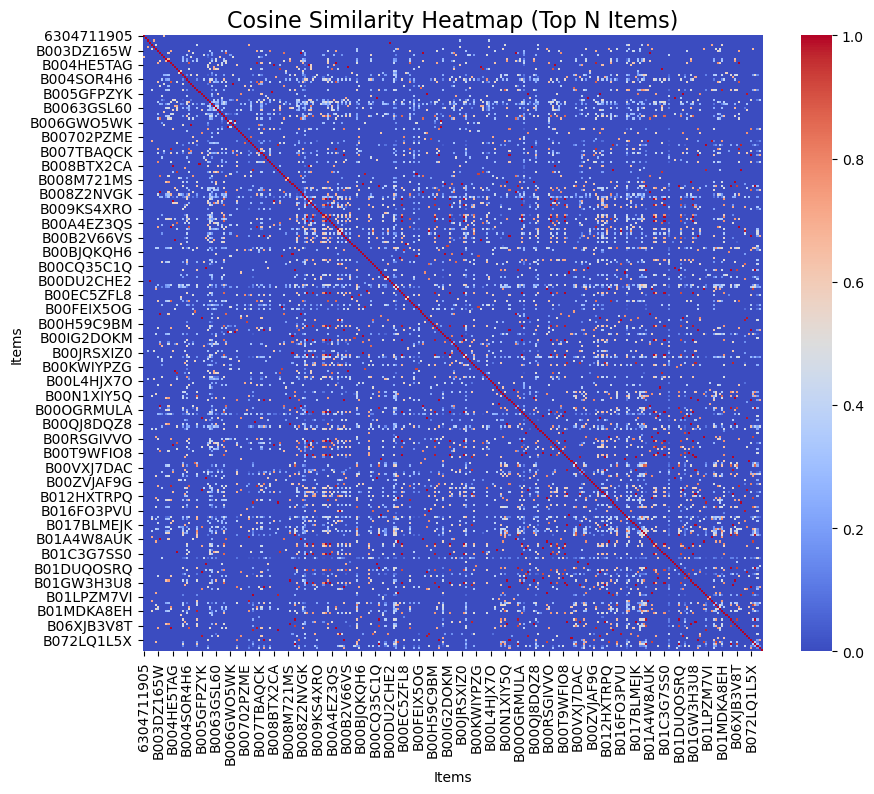

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# 사용자-아이템 행렬 생성 및 코사인 유사도 계산
def calculate_cosine_similarity(df):
    # 사용자-아이템 피벗 테이블 생성
    pivot_table = df.pivot_table(index="parent_asin", columns="user_id", values="rating", fill_value=0)
    
    # 코사인 유사도 계산
    cosine_sim = cosine_similarity(pivot_table)
    
    # 유사도를 데이터프레임으로 변환
    cosine_sim_df = pd.DataFrame(cosine_sim, index=pivot_table.index, columns=pivot_table.index)
    return cosine_sim_df

# 코사인 유사도 히트맵 시각화
def visualize_cosine_similarity(cosine_sim_df, top_n=20):
    # 상위 N개 항목만 선택
    sim_subset = cosine_sim_df.iloc[:top_n, :top_n]
    
    # 히트맵 생성
    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_subset, annot=False, cmap="coolwarm", cbar=True)
    plt.title("Cosine Similarity Heatmap (Top N Items)", fontsize=16)
    plt.xlabel("Items")
    plt.ylabel("Items")
    plt.show()

# 실행
review_path = os.path.abspath("./Data/Amazon/Review/combined_data2.json")
categories = ["Software"]
review = preprocess_review(review_path, categories[0])

# 코사인 유사도 계산 및 시각화
cosine_sim_df = calculate_cosine_similarity(review)
visualize_cosine_similarity(cosine_sim_df, top_n=300)


성능 개선 작업

In [ ]:
def sort_review(review_df):
  # asin별 user_id 개수를 집계하여 인기 아이템 선정
  popular_items = (
      review_df.groupby("parent_asin")["user_id"]
      .count()
      .reset_index(name="num_reviews")
      .sort_values(by="num_reviews", ascending=False)
  )

  # 상위 1000개의 인기 아이템 추출
  popular_item_asins = popular_items.head(1000)["parent_asin"].tolist()

  # 인기 아이템만 포함한 데이터 필터링
  sorted_review_df = review_df[review_df["parent_asin"].isin(popular_item_asins)]
  return sorted_review_df

sorted_review_df = sort_review(review)

특정 카테고리에 한정하여 샘플링

In [ ]:
# def CategoryBasedCF(df, categories):
#     for targetCategory in categories:
#         print(targetCategory+"'s performance")
#         filtered_df = df[df["category"] == targetCategory]
#         cf_review = CF_review(filtered_df)
#         pivot_pandas = cf_review["pivot_pandas"]
#         similarity_score = cf_review["similarity_score"]

#         filtered_df.describe()
        
#         print("Shape of similarity_score:", similarity_score.shape)
#         print("Max similarity:", similarity_score.max())
#         print("Min similarity:", similarity_score.min())
#         print("Mean similarity:", similarity_score.mean())
        
#         train_data, test_data = split_train_test(pivot_pandas, test_ratio=0.2)
#         reconstructed_matrix, explained_variance = apply_svd(train_data, n_components=50)
#         rmse = calculate_rmse(reconstructed_matrix, test_data)
#         print(f"RMSE: {rmse}\n")

In [ ]:
# CategoryBasedCF(review,categories)